# Image Search Using Milvus
In this example we are going to be going over a simple image search example using Milvus. The dataset we are searching through is the Impressionist-Classifier Dataset found on [Kaggle](https://www.kaggle.com/datasets/delayedkarma/impressionist-classifier-data). For this example we have rehosted the data in a public google drive.

For this example we are just using a 1CU instance and using the Torchvision pretrained Resnet50 model for embeddings. Lets get started

## Installing the Requirements
For this example we are going to be using `pymilvus` to connect to use Milvus, `torch` for running the embedding model, `torchvision` for the actual model and preprocessing,`gdown` to download the example dataset and `tqdm` for loading bars.

In [16]:
! pip install pymilvus torch gdown torchvision tqdm

You should consider upgrading via the '/Users/fzliu/.pyenv/bin/python3 -m pip install --upgrade pip' command.


## Grabbing the Data
We are going to use `gdown` to grab the zip from Google Drive and then decompress it with the built in `zipfile` library.

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_'
output = './paintings.zip'
gdown.download(url, output)

In [3]:
import zipfile

with zipfile.ZipFile("./paintings.zip","r") as zip_ref:
    zip_ref.extractall("./paintings")

## Global Arguments
These are some of the main global arugments that we will be using for easier tracking and updating. 

In [17]:
# Zilliz Cloud Setup Arguments
import os
COLLECTION_NAME = 'image_search'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example
URI = os.getenv('VECTOR_DB_URL')  # Endpoint URI obtained from Zilliz Cloud
USER = 'db_admin'  # Username specified when you created this database
PASSWORD = os.getenv('VECTOR_DB_PASS')  # Password set for that account

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3

## Setting Up Milvus
At this point we are going to begin setting up Milvus. The steps are as follows:

1. Connect to the Milvus instance using the provided URI.
2. If the collection already exists, drop it.
3. Create the collection that holds the id, filepath of the image, and image embedding.
4. Create an index on the newly created collection and load it into memory.

Once these steps are done the collection is ready to be inserted into and searched. Any data added will be indexed automatically and be available to search immidiately. If the data is very fresh, the search might be slower as brute force searching will be used on data that is still in process of getting indexed.


In [18]:
from pymilvus import connections

# Connect to the instance
connections.connect(uri=URI, user=USER, password=PASSWORD, secure=True)

In [19]:
from pymilvus import utility

# Remove any previous collections with the same name
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

In [20]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

# Create collection which includes the id, filepath of the image, and image embedding
fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),  # VARCHARS need a maximum length, so for this example they are set to 200 characters
    FieldSchema(name='image_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

In [21]:
# Create an AutoIndex index for collection
index_params = {
    'metric_type':'L2',
    'index_type':"AUTOINDEX",
    'params':{}
}
collection.create_index(field_name="image_embedding", index_params=index_params)
collection.load()

## Inserting the Data
In these next few steps we will be: 
1. Loading the data.
2. Preprocessing the data into batches.
3. Embedding the data.
4. Inserting the data.

For this example we are going use the Resnet50 model provided by `torch` and its model hub. In order to get the embeddings we are taking off the final classification layer, resulting in the model giving us embeddings of size 2048. All the vision models found on `torch` use the same preprocessing that we have included here.

In [9]:
import glob

# Get the filepaths of the images
paths = glob.glob('./paintings/paintings/**/*.jpg', recursive=True)
len(paths)

4978

In [10]:
import torch

# Load the embedding model with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
# Semicolon below is to avoid huge print from model.eval()
;


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/fzliu/.cache/torch/hub/v0.10.0.zip


''

In [11]:
from torchvision import transforms

# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
from PIL import Image
from tqdm import tqdm

# Embed function that embeds the batch and inserts it
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        collection.insert([data[1], output.tolist()])

data_batch = [[],[]]

# Read the images into batches for embedding and insertion
for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[],[]]

# Embed and insert the remainder
if len(data_batch[0]) != 0:
    embed(data_batch)

# Call a flush to index any unsealed segments.
collection.flush()

100%|█████████████████████████████████████████████████████████████████████| 4978/4978 [17:21<00:00,  4.78it/s]


## Performing the Search
With all the data inserted into Milvus we can start performing our searches. In this example we are going to search for two example images. Because we are doing a batch search, the search time is shard across the images of the batch.

In [13]:
import glob

# Get the filepaths of the search images
search_paths = glob.glob('./paintings/test_paintings/**/*.jpg', recursive=True)
len(search_paths)

2

In [14]:
import time
from matplotlib import pyplot as plt

# Embed the search images
def embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        # If more than one image, use squeeze
        if len(ret) > 1:
            return ret.squeeze().tolist()
        # Squeeze would remove batch for single image, so using flatten
        else:
            return torch.flatten(ret, start_dim = 1).tolist()

data_batch = [[],[]]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

embeds = embed(data_batch[0])
start = time.time()
res = collection.search(embeds, anns_field='image_embedding', param={}, limit=TOP_K, output_fields=['filepath'])
finish = time.time()


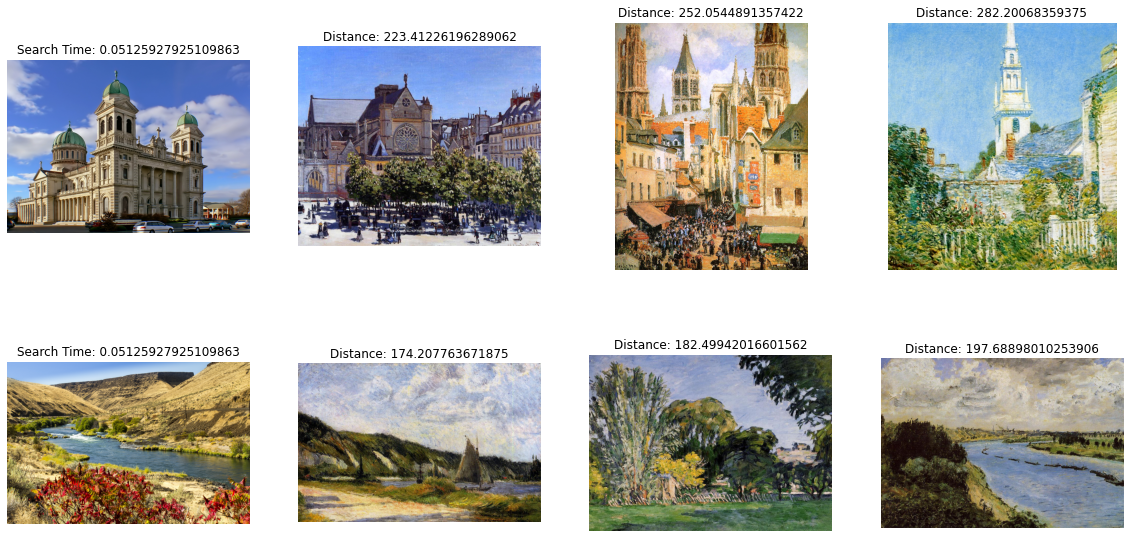

In [15]:
# Show the image results
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))